In [1]:
# API KEY Loading
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH21-LangGraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-LangGraph


# Subgraph

- SubGraph를 사용하면 여러 구성 요소를 포함하는 복잡한 시스템을 구축할 수 있으며, 이러한 구성 요소 자체가 그래프가 될 수 있음 
- 멀티 에이전트 시스템 구축 시 주로 사용

- 고려사항 
    - 상위 그래프와 SubGraph 가 어떻게 통신하는지, 즉 그래프 실행 중에 상태(State) 를 서로 어떻게 전달하는지
    - 시나리오 1 
        - 상위 그래프와 서브그래프가 "스키마 키를 공유" 하는 경우 
        - 컴파일된 서브그래프로 노드 추가
        - (비유1) 공동 작업 문서 
        - (비유2) 선생님이 준 자료를 가지고, 조별 발표에서 추가 내용을 붙여 제출
    - 시나리오 2
        - 상위 그래프와 서브그래프가 "서로 다른 스키마"를 가지는 경우 
        - 서브그래프를 호출하는 노드 함수 추가
        - (비유1) 각각 독립된 문서
        - (비유2) 조별 발표에서 자체 조사를 진행한 후, 발표 요약만 제출 

# 시나리오 1 : 스키마 키를 공유하는 경우 

- 컴파일된 SubGraph로 노드 추가 
- 상위 그래프와 서브 그래프가 State Key를 통해 통신하는 것이 일반적 

In [3]:
from langgraph.graph import START, END, StateGraph
from typing import TypedDict

In [4]:
# SubGraph State
# 부모 그래프와 공유되는 name 키와 서브그래프 전용 family_name 키 포함
class ChildState(TypedDict):
    name: str 
    family_name: str


# 서브그래프의 첫 번째 노드, family_name 키에 초기값 설정
def subgraph_node_1(state: ChildState):
    return {"family_name": "Lee"}


# 서브그래프의 두 번째 노드, 서브그래프 전용 family_name 키와 공유 name 키를 결합하여 새로운 상태 생성
def subgraph_node_2(state: ChildState):
    return {"name": f'{state["name"]} {state["family_name"]}'}


# Graph
subgraph_builder = StateGraph(ChildState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")

subgraph = subgraph_builder.compile()

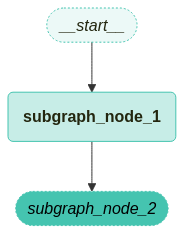

In [5]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(subgraph, xray=True)

In [6]:
# 부모 그래프의 상태 정의 (name 키만 포함)
class ParentState(TypedDict):
    name: str
    company: str


# 부모 그래프의 첫 번째 노드, name 키의 값을 수정하여 새로운 상태 생성
def node_1(state: ParentState):
    return {"name": f'My name is {state["name"]}'}


# Graph
builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", subgraph)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

graph = builder.compile()

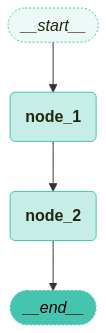

In [7]:
visualize_graph(graph, xray=True)

In [9]:
# 그래프 스트림에서 청크 단위로 데이터 처리 및 각 청크 출력
for chunk in graph.stream({"name": "YoungHee"}):
    print(chunk)

{'node_1': {'name': 'My name is YoungHee'}}
{'node_2': {'name': 'My name is YoungHee Lee'}}


In [10]:
# 그래프 스트리밍 처리를 통한 서브그래프 데이터 청크 단위 순차 출력
# subgraphs 파라미터를 True로 설정하여 하위 그래프 포함 스트리밍 처리
for chunk in graph.stream({"name": "YoungSoo"}, subgraphs=True):
    print(chunk)

((), {'node_1': {'name': 'My name is YoungSoo'}})
(('node_2:962d9285-865c-69d7-0e5a-e8d4c0ae4ac8',), {'subgraph_node_1': {'family_name': 'Lee'}})
(('node_2:962d9285-865c-69d7-0e5a-e8d4c0ae4ac8',), {'subgraph_node_2': {'name': 'My name is YoungSoo Lee'}})
((), {'node_2': {'name': 'My name is YoungSoo Lee'}})


# 시나리오 2 : 스키마 키를 공유하지 않는 경우

- 하위 그래프를 호출하는 노드 함수 추가 
    - 이 함수는 하위 그래프를 호출하기 전에 상위 상태(Parent State)를 하위 그래프 상태(Child State)로 변환하고, 
    - 노드에서 상태 업데이트를 반환하기 전에 결과를 다시 상위 상태(Parent State)로 변환
- 동일한 노드 내에서 두 개 이상의 subgraph를 호출 할 수 없음 

In [14]:
# 서브그래프의 상태 타입 정의 (부모 그래프와 키를 공유하지 않음)
class ChildState(TypedDict):
    # 부모 그래프와 공유되지 않는 키들
    name: str


# 서브그래프의 첫 번째 노드: name 키에 초기값 설정
def subgraph_node_1(state: ChildState):
    return {"name": "YoungHee " + state["name"]}


# 서브그래프의 두 번째 노드: name 값 그대로 반환
def subgraph_node_2(state: ChildState):
    return {"name": f'My name is {state["name"]}'}


# 서브그래프 빌더 초기화 및 노드 연결 구성
subgraph_builder = StateGraph(ChildState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()


# 부모 그래프의 상태 타입 정의
class ParentState(TypedDict):
    family_name: str
    full_name: str


# 부모 그래프의 첫 번째 노드: family_name 값 그대로 반환
def node_1(state: ParentState):
    return {"family_name": state["family_name"]}


# 부모 그래프의 두 번째 노드: 서브그래프와 상태 변환 및 결과 처리
def node_2(state: ParentState):
    # 부모 상태를 서브그래프 상태로 변환
    response = subgraph.invoke({"name": state["family_name"]})
    # 서브그래프 응답을 부모 상태로 변환
    return {"full_name": response["name"]}


# 부모 그래프 빌더 초기화 및 노드 연결 구성
builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)

# 컴파일된 서브그래프 대신 서브그래프를 호출하는 node_2 함수 사용
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)
graph = builder.compile()

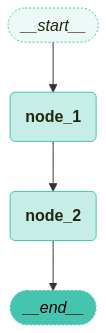

In [15]:
visualize_graph(graph, xray=True)

In [16]:
for chunk in graph.stream({"family_name": "Kim"}, subgraphs=True):
    print(chunk)

((), {'node_1': {'family_name': 'Kim'}})
(('node_2:604b3bbc-48d5-5923-62f2-1d8354324f09',), {'subgraph_node_1': {'name': 'YoungHee Kim'}})
(('node_2:604b3bbc-48d5-5923-62f2-1d8354324f09',), {'subgraph_node_2': {'name': 'My name is YoungHee Kim'}})
((), {'node_2': {'full_name': 'My name is YoungHee Kim'}})


-----
** End of Documents **